Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [84]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import os
from glob import glob
from tensorflow.keras.callbacks import ReduceLROnPlateau

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify the path to your zip file in Google Drive
zip_path = '/content/drive/My Drive/CNN_assignment.zip'
# Unzip the file into a folder in Colab's local filesystem (e.g., /content/CNN_assignment)
!unzip -q "{zip_path}" -d /content/CNN_assignment

replace /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [78]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [79]:
#Print count of image file (with extension .jpg) for both train and test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,                # Seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to target dimensions
    validation_split=0.2,   # Validation split
    subset='training',
    batch_size=batch_size    # Number of images per batch
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,               # Ensures reproducibility
    image_size=(img_height, img_width),  # Resize images to the target dimensions
    validation_split=0.2,   # Validation split
    subset='validation',
    batch_size=batch_size   # Batch size for validation data
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Visualize the data

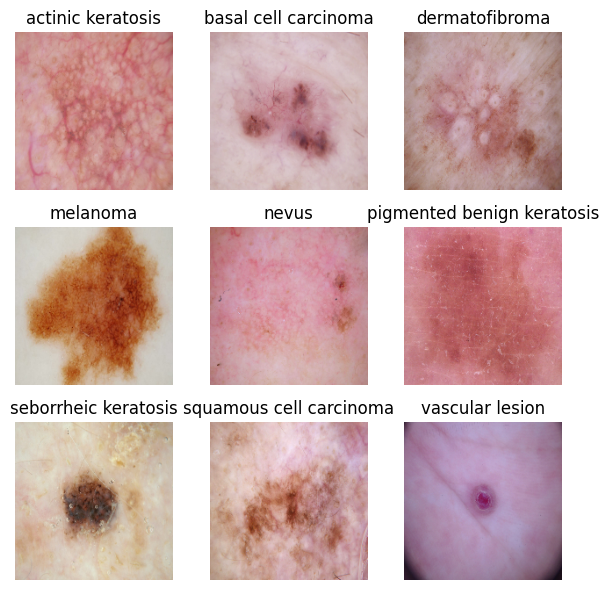

In [ ]:
# Dictionary to store one image per class
images_per_class = {}

# Loop over the training dataset until we have one image for each class
for images, labels in train_ds:
    for img, label in zip(images, labels):
        label_idx = np.argmax(label) if label.ndim > 0 and label.shape[0] > 1 else int(label)
        if label_idx not in images_per_class:
            images_per_class[label_idx] = img.numpy()
    if len(images_per_class) == len(train_ds.class_names):
        break

# Plot one image per class
plt.figure(figsize=(6, 6))
for i in range(len(train_ds.class_names)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_per_class[i].astype("uint8"))
    plt.title(train_ds.class_names[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
#Model 1 - Basic model without normalization,agmentation
num_classes = 9

model = models.Sequential()

# Explicit input layer (defining the input shape)
model.add(tf.keras.Input(shape=(img_height, img_width, 3)))

# Normalization: Scale pixel values from [0, 255] to [0, 1]
model.add(layers.Rescaling(1./255))

# First convolutional block
model.add(layers.Conv2D(16, (3,3), activation='relu'))  # 16 filters, kernel size 3x3
model.add(layers.MaxPooling2D((2,2)))                     # MaxPooling with pool size 2x2

# Second convolutional block
model.add(layers.Conv2D(32, (3,3), activation='relu'))  # 32 filters, kernel size 3x3
model.add(layers.MaxPooling2D((2,2)))                     # MaxPooling with pool size 2x2

# Third convolutional block
model.add(layers.Conv2D(64, (3,3), activation='relu'))  # 64 filters, kernel size 3x3
model.add(layers.MaxPooling2D((2,2)))                     # MaxPooling with pool size 2x2

# Flatten and Dense layers
model.add(layers.Flatten())                             # Flatten the output for the dense layer
model.add(layers.Dense(128, activation='relu'))         # Dense layer with 128 neurons


# Output layer: one neuron per class with softmax activation for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301,673 (12.59 MB)

 Trainable params: 3,301,673 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

### Test the model

In [ ]:
 # test model for 20 epocs
 epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.1973 - loss: 3.5631 - val_accuracy: 0.2796 - val_loss: 1.9809
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.2363 - loss: 2.0326 - val_accuracy: 0.2595 - val_loss: 2.0083
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.2740 - loss: 1.9337 - val_accuracy: 0.3110 - val_loss: 1.8367
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 999ms/step - accuracy: 0.2974 - loss: 1.8634 - val_accuracy: 0.4295 - val_loss: 1.6727
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4132 - loss: 1.6652 - val_accuracy: 0.3311 - val_loss: 1.8356
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.4494 - loss: 1.5142 - val_accuracy: 0.4832 - val_loss: 1.5049
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4462 - loss: 1.4941 - val_accuracy: 0.5034 - val_loss: 1.4383
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4978 - loss: 1.4138 - val_accuracy: 0.5391 - val_lo

#### Visualizing training results

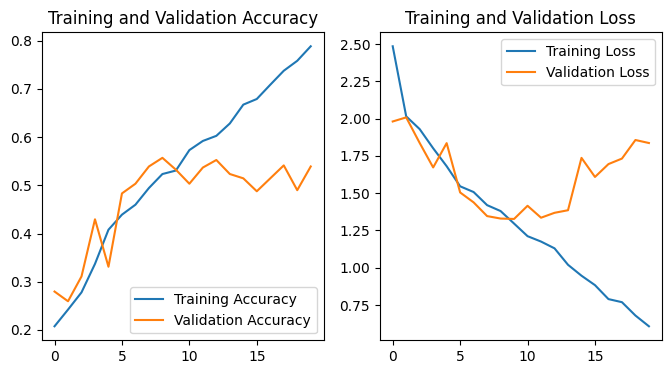

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Observations :
1. Significant Gap Between Training and Validation Accuracy
The model performs much better on the training set (88% accuracy) compared to the validation set (54% accuracy). This gap suggests that the model is likely overfitting. It has learned patterns specific to the training data but fails to generalize well to unseen data.

2. Higher Validation Loss
The validation loss (1.8364) is significantly higher than the training loss (0.57). This further indicates that the model struggles with the validation set, reinforcing the signs of overfitting.

Recommendation :   
To try some of below mentioned techniques -
1. Increase Regularization (Dropout, Batch Normalization etc)
2. Data Augmentation
3. Early Stopping

#### Data Agumentation strategy
Data augmentation is a technique used to artificially increase the size of a training dataset by applying random transformations to the existing data, such as rotations, flips, zooms, shifts, etc.
This technique is particularly useful when the dataset is small or when overfitting occurs.

In [ ]:
# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),   # Randomly flip images horizontally
    layers.RandomRotation(0.2),          # Randomly rotate images by up to 20%
    layers.RandomZoom(0.2),              # Randomly rotate images by up to 20%
    layers.RandomContrast(0.1),           # Randomly create contrast images by up to 10%
    layers.Resizing(img_height, img_width) # Ensure consistent output size
])

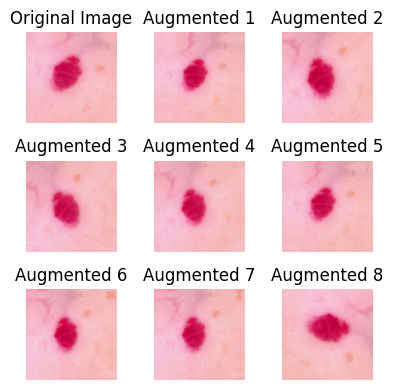

In [ ]:
# visualize how augmentation strategy works for one instance of training image.
# Get one batch from the training dataset
for images, labels in train_ds.take(1):
    sample_image = images[0]  # Take the first image from the batch
    break

# Visualize the original image and several augmented versions
plt.figure(figsize=(4, 4))
plt.subplot(3, 3, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original Image")
plt.axis('off')

# Apply data augmentation multiple times to show variety
num_augmented_images = 8  # Number of augmented versions to display
for i in range(num_augmented_images):
    # Expand dimensions to create a batch of one image
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
    plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(f"Augmented {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Create the model, compile and train the model on agumented data

In [49]:
#Model 2  - with data agumentation
num_classes = 9
model = models.Sequential()

# Explicit input layer (defining the input shape)
model.add(tf.keras.Input(shape=(img_height, img_width, 3)))

# Data augmentation layer (active only during training)
model.add(data_augmentation)

# Normalization: Scale pixel values from [0, 255] to [0, 1]
model.add(layers.Rescaling(1./255))

# First convolutional block
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1)) # Dropout layer to reduce overfitting

# Output layer: one neuron per class with softmax activation for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax'))



In [50]:
# Choose an appropriate optimizer and loss function
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
# Display the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301,673 (12.59 MB)

 Trainable params: 3,301,673 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.1823 - loss: 2.4708 - val_accuracy: 0.2170 - val_loss: 2.0118
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.2428 - loss: 2.0157 - val_accuracy: 0.3110 - val_loss: 1.8656
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3324 - loss: 1.8427 - val_accuracy: 0.4340 - val_loss: 1.6894
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3891 - loss: 1.7462 - val_accuracy: 0.3624 - val_loss: 1.8682
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4099 - loss: 1.6643 - val_accuracy: 0.4027 - val_loss: 1.6625
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.4236 - loss: 1.6190 - val_accuracy: 0.4944 - val_loss: 1.4857
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.4331 - loss: 1.5516 - val_accuracy: 0.3691 - val_loss: 1.7687
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.4543 - loss: 1.5152 - val_accuracy: 0.5503 - val_loss:

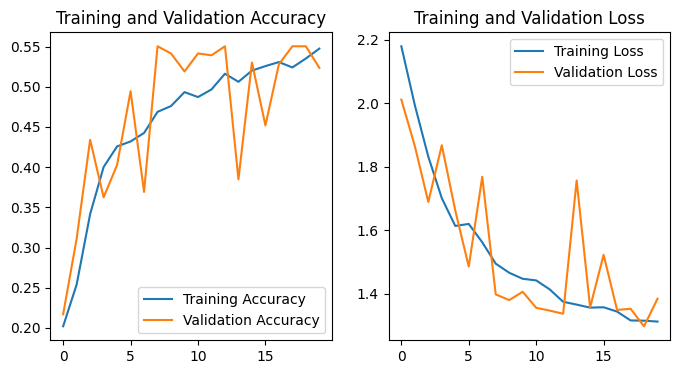

In [54]:
# visualizating the accuracy and loss of train and test after augmentation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observations

1. Similar Training and Validation Accuracies:
The gap between the training accuracy (54.68%) and the validation accuracy (52.35%) is relatively small, indicating that the model is not overfitting heavily.

2. Moderate Performance Overall:
Both accuracies are around the mid-50% range. This suggests the model may not be learning sufficiently discriminative features to achieve higher accuracy—often referred to as underfitting.

Recommendations

Hyperparameter Tuning: Adjust the learning rate, batch size, or optimizer.
Data Quality and Class Imbalance: Ensure your dataset is large enough, balanced, and accurately labeled.  
Increase Model Capacity: Add more layers or filters if your dataset is large enough to support a more complex model.  

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [72]:
## Getting dataframe using path list and classes before Augmentor
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
# Get the distribution of class
original_df['Label'].value_counts()



,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


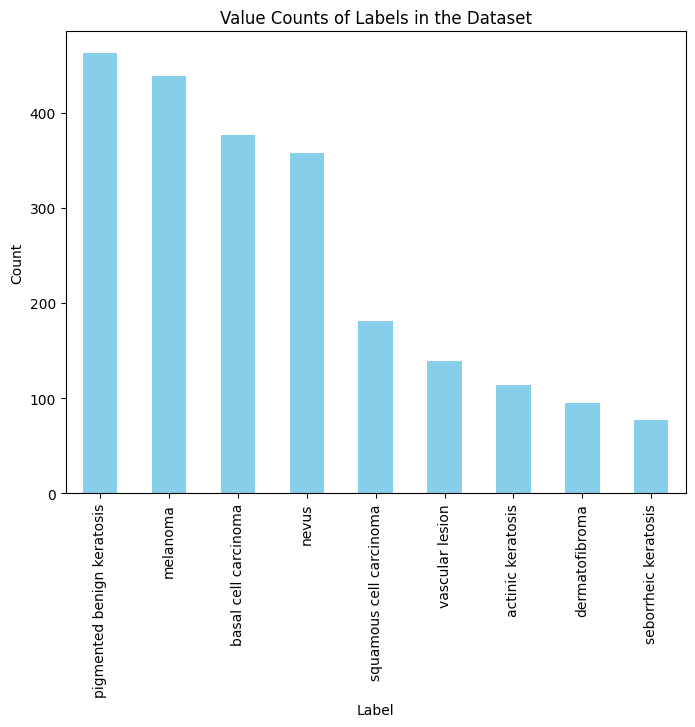

In [69]:
# Calculate value counts for each class label
label_counts = original_df['Label'].value_counts()

# Plot the bar graph using pandas built-in plotting or matplotlib
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Value Counts of Labels in the Dataset')
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
*Least Number of Samples:*  
The class with the fewest samples is **seborrheic** keratosis with only 77 samples.  
#### - Which classes dominate the data in terms proportionate number of samples?

*Dominant classes:*  
The classes that dominate in terms of the number of samples are:  

**pigmented benign keratosis** (462 samples)  
**melanoma** (438 samples)  
**basal cell carcinoma** (376 samples)  
**nevus** (357 samples)  


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [75]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [81]:
path_to_training_dataset="/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CD435C22090>: 100%|██████████| 500/500 [00:17<00:00, 29.12 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CD436726AD0>: 100%|██████████| 500/500 [00:16<00:00, 30.72 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CD436672110>: 100%|██████████| 500/500 [00:16<00:00, 29.47 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CD435CDAD90>: 100%|██████████| 500/500 [01:42<00:00,  4.88 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7CD440113E50>: 100%|██████████| 500/500 [01:15<00:00,  6.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CD435CD0690>: 100%|██████████| 500/500 [00:16<00:00, 30.82 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CD4365A39D0>: 100%|██████████| 500/500 [00:41<00:00, 12.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CD436683D50>: 100%|██████████| 500/500 [00:16<00:00, 30.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7CD436545010>: 100%|██████████| 500/500 [00:16<00:00, 29.79 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [82]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [96]:
# Getting the new file path list after using augmentor
from glob import glob
import os
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list_new[:2]

['/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028451.jpg_ffae2493-1e08-416c-9fb0-af5243a7f78b.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024839.jpg_92f07fcf-80b2-41e0-9e45-eb6895514721.jpg']

In [95]:
# Getting the new file path list of classes after using augmentor
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:10]

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis']

In [97]:
# Create new dataframe dictionary using file paths and classes
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [98]:
# Merge both dataframes
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [99]:
# value count of new df
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [100]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [101]:
data_dir_train=data_dir_train #"Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [103]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [104]:
#Model 3  - after class imbalance
num_classes = 9
model = models.Sequential()

# Explicit input layer (defining the input shape)
model.add(tf.keras.Input(shape=(img_height, img_width, 3)))

# Data augmentation layer (active only during training)
model.add(data_augmentation)

# Normalization: Scale pixel values from [0, 255] to [0, 1]
model.add(layers.Rescaling(1./255))

# First convolutional block
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1)) # Dropout layer to reduce overfitting

# Output layer: one neuron per class with softmax activation for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax'))


### Compile and train your model (Choose optimizer and loss function appropriately)

In [105]:
# Choose an appropriate optimizer and loss function
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [106]:
## Train model using use 30 epochs.
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.1809 - loss: 2.1793 - val_accuracy: 0.3653 - val_loss: 1.7099
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.3701 - loss: 1.6897 - val_accuracy: 0.4662 - val_loss: 1.4871
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.4122 - loss: 1.5640 - val_accuracy: 0.4633 - val_loss: 1.4059
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.4619 - loss: 1.4674 - val_accuracy: 0.4402 - val_loss: 1.4390
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.4737 - loss: 1.4146 - val_accuracy: 0.5093 - val_loss: 1.3126
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.4789 - loss: 1.3690 - val_accuracy: 0.5523 - val_loss: 1.1998
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.5117 - loss: 1.2954 - val_accuracy: 0.5360 - val_loss: 1.2515
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.5108 - loss: 1.2790 - val_accu

Observations

1. Performance Balance:
The training and validation accuracies are close (71.26% vs. 68.60%), and the losses are also similar. This suggests that the model is generalizing reasonably well and is not overfitting drastically.

2. Room for Improvement:
While the model achieves moderate accuracy, there is potential to improve performance further. Strategies could include:
- Hyperparameter Tuning: Experiment with learning rates, batch sizes, or regularization techniques.
- Increasing Model Complexity: Adjust the architecture to better capture the patterns in the data.

Overall, the model is performing reasonably, after introducing
- Regularization techniques (like dropout),
- Data augmentation
- Class imbalance

but, refinement could help increase both training and validation accuracies while potentially reducing the loss values.

### Lets try building a model 4 with hyper parameter tuning and check if same improves the model performance.

In [107]:
# Experimenting with 'Learning rate' parameter. This callback monitors a specific metric during training and reduces the learning rate when that metric stops improving.
Hyper_tuning_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 5,
                                 verbose = 1,
                                 factor = 0.2,
                                 min_lr = 1e-7
                                 )

In [108]:
## Train model using 30 epochs.
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [Hyper_tuning_lr]
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.7380 - loss: 0.7238 - val_accuracy: 0.6875 - val_loss: 0.9475 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7300 - loss: 0.7351 - val_accuracy: 0.7632 - val_loss: 0.6496 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.7404 - loss: 0.6790 - val_accuracy: 0.7231 - val_loss: 0.7824 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.7298 - loss: 0.7469 - val_accuracy: 0.7691 - val_loss: 0.6329 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.7386 - loss: 0.6895 - val_accuracy: 0.6741 - val_loss: 0.9659 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7536 - loss: 0.6720 - val_accuracy: 0.5419 - val_loss: 1.5783 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.7329 - loss: 0.

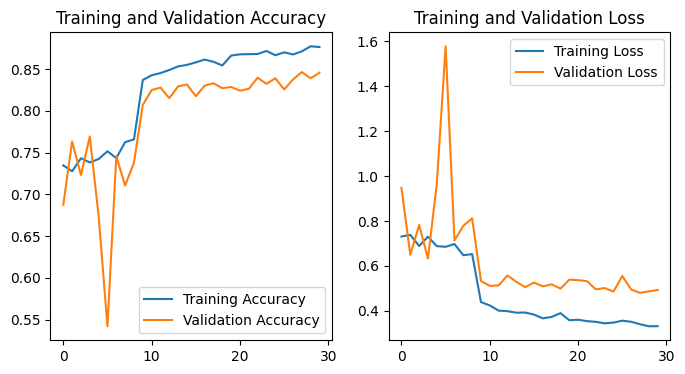

In [109]:
# visualizating the accuracy and loss of train and test after augmentation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observation

# **Training Accuracy** **(87.79%)** vs. **Validation Accuracy** **(84.56%)**:
The high accuracies in both training and validation sets show that the model is learning well. The small gap suggests only minor overfitting, if any.

In [111]:
# Additioanl step - Accuracy on Test data

test_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,image_size=(img_width,img_height),
                                                            shuffle=False,batch_size=120)
predictions=model.predict(test_ds)
score = tf.nn.softmax(predictions)
_, labels = tuple(zip(*test_ds))
print(labels)
print()
print(np.argmax(score,axis=-1))
print()

from sklearn.metrics import accuracy_score
print('Test Accuracy')
accuracy_score(labels[0].numpy(),np.argmax(score,axis=-1))

Found 118 files belonging to 9 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
(<tf.Tensor: shape=(118,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 8, 8, 8], dtype=int32)>,)

[6 4 4 4 4 7 1 4 4 4 4 1 4 0 4 7 1 2 1 1 1 1 4 5 1 1 5 1 7 1 1 0 3 3 4 3 3
 3 5 1 2 2 2 2 2 5 2 7 4 5 4 4 4 3 7 5 4 4 4 4 4 3 4 3 4 4 4 4 4 4 4 4 4 4
 5 4 4 4 4 4 2 5 5 5 5 7 3 5 0 5 5 5 5 0 5 7 3 3 3 3 8 4 4 4 1 7 5 1 5 1 5
 5 7 7 7 8 1 8]

Test Accuracy


0.4322033898305085

The test accuracy of approximately 43.22% indicates that the model's performance on unseen test data is quite low.

This could be because -   
Model might be overfitted on training data,   
or Test set differs significantly from the training set.  
Further improvements in model design, training strategy, or data collection are necessary.